# stMLE clustering 

**stMLE** is a novel normalisation method implemented in *stLearn* software.   
It's designed for **s**patial **t**ranscriptomics data and utilised tissue **M**orphology, spatial **L**ocation, and gene **E**xpression.

This tutorial demonstrates how to use *stLearn* to perform **stMLE** clustering for spatial transcriptomics data

In this tutorial we focus on **Mouse Brain (Coronal)** Visium dataset from [10x genomics website](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Adult_Mouse_Brain).

## Read data

In [1]:
# import module
import stlearn as st
from pathlib import Path

In [2]:
# specify PATH to data
BASE_PATH = Path("/90days/uqxtan9/10x_Visium/V1_Adult_Mouse_Brain")
CM_PATH = BASE_PATH / "V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.h5"
IMG_PATH = BASE_PATH / "spatial/tissue_hires_image.png"
SPOT_PATH = BASE_PATH / "spatial/tissue_positions_list.csv"
SCALE_PATH = BASE_PATH / "spatial/scalefactors_json.json"

# spot tile is the intermediate result of image pre-processing
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
# load data
data = st.read.file_10x_h5(CM_PATH)
data.var_names_make_unique()
st.add.image(adata=data, imgpath=IMG_PATH)
st.add.positions(data,position_filepath = SPOT_PATH,
                scale_filepath = SCALE_PATH,
                quality="high")


Added tissue image to the object!


## Preprocessing

In [4]:
# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.pp.scale(data)

filtered out 12145 genes that are detected in less than 3 cells
normalizing counts per cell
Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


## Image processing

In [5]:
# pre-processing for spot image
st.pp.tiling(data, TILE_PATH, crop_size=40)

# this step uses deep learning model to extract high-level features from tile images
# may need few minutes to be completed
st.pp.extract_feature(data)

The morphology feature is added to adata.obsm['X_morphology']!


In [6]:
# run PCA for gene expression data
st.em.run_pca(data,n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


## Normalising by image and disk smoothing

In [7]:
# apply stMLE to normalise PCA
# radius=50 includes two units of surrounding spots
st.spatial.morphology.adjust(data,use_data="X_pca",radius=50,method="mean")
data.obsm['X_pca'] = data.obsm['X_pca_morphology']

The data adjusted by morphology is added to adata.obsm['X_pca_morphology']


Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


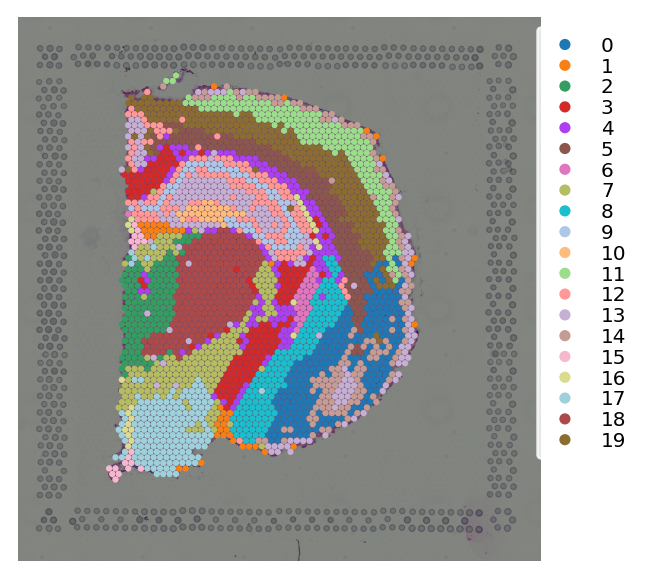

In [8]:
# K-means clustering on stMLE normalised PCA
st.tl.clustering.kmeans(data,n_clusters=20, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data, use_label="X_pca_kmeans")

## Perform stMLE clustering

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


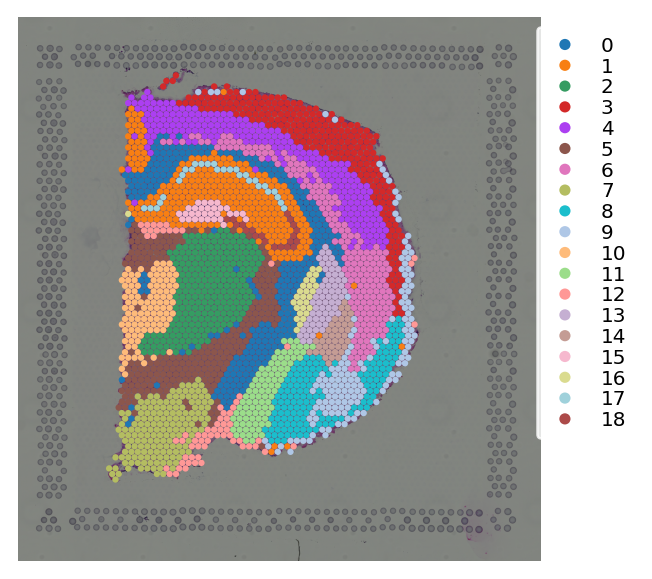

In [9]:
# louvain clustering on stMLE normalised PCA
st.pp.neighbors(data,n_neighbors=10,use_rep='X_pca')
st.tl.clustering.louvain(data)
st.pl.cluster_plot(data,use_label="louvain")